In [ ]:
I'm

In [ ]:
pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import ipywidgets as widgets
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from piq import brisque, total_variation, TVLoss
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')

1. Collect the dataset of 20 color images from open sources. It can be various  images of people/pets/nature/city etc.

In [ ]:
PE = [4, 5, 3, 5, 4, 5, 4, 4, 3, 4, 3, 3, 5, 4, 4, 3, 4, 5, 2, 2]

In [ ]:
directory_path = '/content'
image_files = [os.path.join(directory_path, f) for f in sorted(os.listdir(directory_path)) if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
image_paths, ratings = [], []

2. Sort these images in the descending order according to your personal opinion about its perceptual quality https://en.wikipedia.org/wiki/Image_quality. For example, mark them from 5 to 1, where 5=excellent quality, 1=poor quality. Plot the marks as a captions for the images in the Notebook.

In [ ]:
if len(image_files) != len(PE):
    raise ValueError("La cantidad de imágenes y la cantidad de calificaciones en PE no coinciden.")

df_images = pd.DataFrame({
    'Image': image_files,
    'Rating': PE
})

print(df_images)

              Image  Rating
0    /content/1.jpg       4
1   /content/10.jpg       5
2   /content/11.jpg       3
3   /content/12.jpg       5
4   /content/13.jpg       4
5   /content/14.jpg       5
6   /content/15.jpg       4
7   /content/16.jpg       4
8   /content/17.jpg       3
9   /content/18.jpg       4
10  /content/19.jpg       3
11   /content/2.jpg       3
12  /content/20.jpg       5
13   /content/3.jpg       4
14   /content/4.jpg       4
15   /content/5.jpg       3
16   /content/6.jpg       4
17   /content/7.jpg       5
18   /content/8.jpg       2
19   /content/9.jpg       2


In [ ]:
df_images= df_images.sort_values(by='Rating', ascending=False).reset_index(drop=True)
print(df_images)

              Image  Rating
0    /content/7.jpg       5
1   /content/12.jpg       5
2   /content/14.jpg       5
3   /content/10.jpg       5
4   /content/20.jpg       5
5    /content/1.jpg       4
6    /content/4.jpg       4
7   /content/13.jpg       4
8   /content/15.jpg       4
9   /content/16.jpg       4
10   /content/6.jpg       4
11  /content/18.jpg       4
12   /content/3.jpg       4
13   /content/5.jpg       3
14  /content/19.jpg       3
15   /content/2.jpg       3
16  /content/17.jpg       3
17  /content/11.jpg       3
18   /content/8.jpg       2
19   /content/9.jpg       2


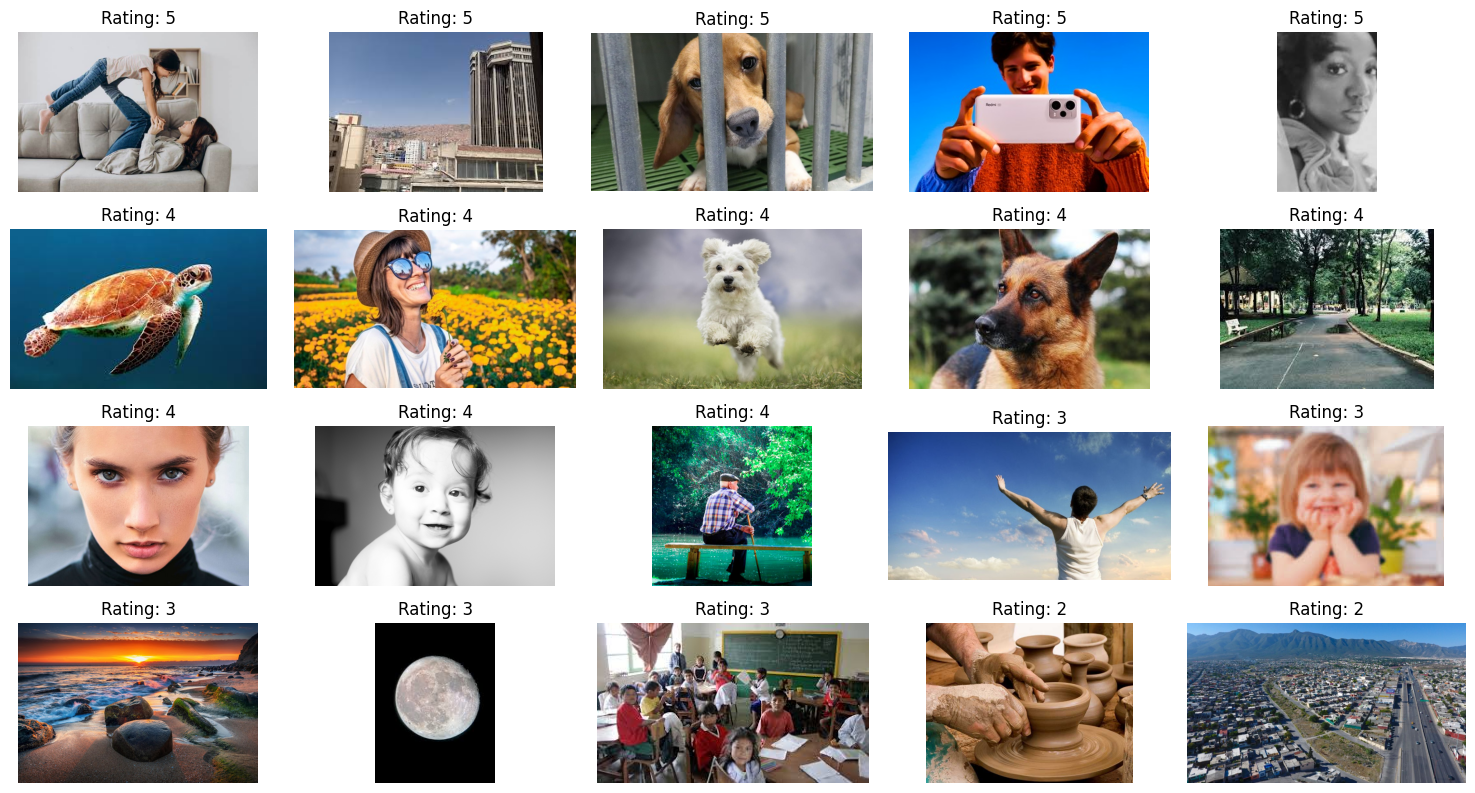

In [ ]:
plt.figure(figsize=(15, 10))
columns = 5
for i, row in df_images.iterrows():
    img = Image.open(row['Image'])
    plt.subplot(len(df_images) // columns + 1, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Rating: {row['Rating']}", fontsize=12)
plt.tight_layout()
plt.show()

3.  Evaluate No-Reference image quality metrics TV, BRISQUE and NIMA estimating their quality (use, for example, implementations from https://github.com/photosynthesis-team/piq, https://github.com/aigagror/ML-Aesthetics-NIMA).

In [ ]:
def calculate_brisque(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1)[None, ...] / 255.


    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    score = brisque(img_tensor, data_range=1., reduction='none')
    return score.item()

def calculate_total_variation(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1)[None, ...] / 255.

    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    tv_index = total_variation(img_tensor)
    tv_loss = TVLoss(reduction='none')(img_tensor)

    return tv_index.item(), tv_loss.item()

def rate(img_path):
    num_classes = 10

    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Softmax(1)
    )


    assert os.path.exists('/content/dense121_all.pt')
    model_ft.load_state_dict(torch.load('/content/dense121_all.pt', map_location=torch.device('cpu')))



    img = Image.open(img_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    img = transform(img)
    img.to('cpu')
    model_ft.to('cpu')
    with torch.no_grad():
        scores = model_ft(img.view(1,3,224,224))
        weighted_votes = torch.arange(10, dtype=torch.float) + 1
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1,1)), 2)).sum(dim=1))


    return mean.item()

In [ ]:
tqdm.pandas()

df_images['BRISQUE'] = df_images['Image'].progress_apply(calculate_brisque)

df_images[['TV Index', 'TV Loss']] = df_images['Image'].progress_apply(
    lambda x: pd.Series(calculate_total_variation(x))
)

df_images['NIMA Score'] = df_images['Image'].progress_apply(rate)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
df_images

,Image,Rating,BRISQUE,TV Index,TV Loss,NIMA Score
0,/content/7.jpg,5,41.205261,55.994415,55.994415,5.430527
1,/content/12.jpg,5,65.787292,64.793266,64.793266,5.381190
2,/content/14.jpg,5,12.903503,61.496235,61.496235,5.420492
3,/content/10.jpg,5,5.367859,38.190781,38.190781,5.416273
4,/content/20.jpg,5,34.103699,12.610993,12.610993,5.412664
5,/content/1.jpg,4,46.020203,42.303246,42.303246,5.406474
6,/content/4.jpg,4,28.729187,66.040939,66.040939,5.427956
7,/content/13.jpg,4,39.241394,42.677582,42.677582,5.432786
8,/content/15.jpg,4,30.673035,27.011274,27.011274,5.416831
9,/content/16.jpg,4,26.755066,71.610031,71.610031,5.420475


4. Compute Pearson correlation coefficients between the metric scores and your personal estimates.

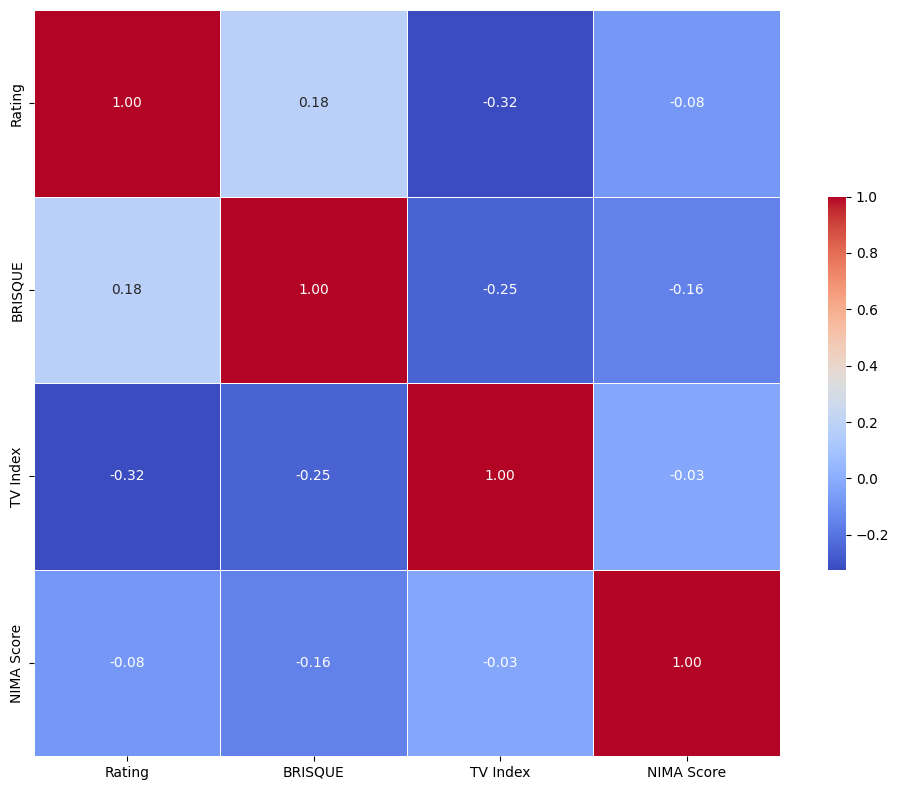

In [ ]:
corr = df_images[['Rating', 'BRISQUE', 'TV Index', 'NIMA Score']].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()

plt.show()

5. Choose the best metric, which is more correlated with the human opinion.

Although BRISQUE has a weak positive correlation with human ratings (0.18), it’s important to remember that this metric follows the "smaller is better" principle, meaning a lower BRISQUE score indicates better image quality. Despite the correlation being relatively weak, BRISQUE remains the best choice to reflect human opinion on image quality, as it captures certain aspects of perceived visual quality.

Therefore, despite the weak positive correlation, BRISQUE is the most suitable metric for evaluating image quality in alignment with human perception.